In [149]:
%%html
<style>
    .container {
        width: 85% !important;
    }
</style>

In [150]:
import os
import numpy as np
from BCI2000Tools.FileReader import bcistream
from BCI2000Tools.Electrodes import *
from BCI2000Tools.Plotting import *
import mne 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyprep.prep_pipeline import PrepPipeline, NoisyChannels

import eeg_dict
import tools_mi as mi

# After changes to the class in test
import importlib
importlib.reload(mi)
importlib.reload(eeg_dict)

<module 'eeg_dict' from '/mnt/c/Users/scana/Dropbox/WCornell/develop/motorimagery/eeg_dict.py'>

In [151]:
MI = mi.tools_mi()

In [152]:
file_path = '/mnt/c/Users/scana/Desktop/MI_test/'
if 1: 
    file_name = 'RI21-ses01-motor.dat'
    #file_name = 'RI65-ses01-motor.dat'
    #file_name = 'RI32-ses01-motor.dat'

if 0: 
    file_name = 'GS4005-ses01-motor.dat'
    
if 0:
    #file_name = 'sub-BIpeds149_ses-42_task-MotorImag_run-01.dat'
    file_name = 'sub-BIpeds166_ses-01_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds166_ses-04_task-MotorImag_run-01.dat'
    #file_name = 'sub-BIpeds173_ses-01_task-MotorImag_run-01.dat'
    
ch_location = eeg_dict.ch_location

In [153]:
# Import .dat file
signal, states, fs, ch_names, blockSize, montage_type = MI.import_file_dat(file_path+'/', file_name)

if montage_type == 'DSI_24': ch_info = 'DSI24_location.txt'
elif montage_type == 'EGI_128': ch_info = 'EGI128_location.txt'
elif montage_type == 'GTEC_32': ch_info = 'GTEC32_location.txt'


EEG channels: 20 Total ticks: 125400
Each tick corresponds to [s]: 0.0033333333333333335
Sampling rate [Hz]: 300.0 ~~~ Time on file [s]: 418.0
Montage Detected: DSI_24
Signal range: [-9791.0390625, -481.2362976074219, 2824.9404296875]

StimulusCode: (array([0, 1, 2, 3]), array([96600,  7200,  7200, 14400]))


In [154]:
#b = bcistream(file_path + file_name)
#signal, states = b.decode()
#b.params['Stimuli']

In [155]:
fileTime, nBlocks, trialsPerBlock, initialSec, stimSec, taskSec = MI.evaluate_mi_paradigm(signal=signal, states=states, fs=fs, blockSize=blockSize, verbose=True)
nSplit = 6
rejectSec = taskSec - 9 # 1 [s]

Block size [12] fits perfectly in sample frequency [25.0]!
This file contains 100.0% of MI paradigm
    Number of full blocks: 8
    Additional trials: 0.0


In [156]:
fmin = 1
fmax = 40

tmin = 0
twindow = (taskSec - rejectSec) # e.g. 9
tmax = twindow/nSplit # e.g. 1.5

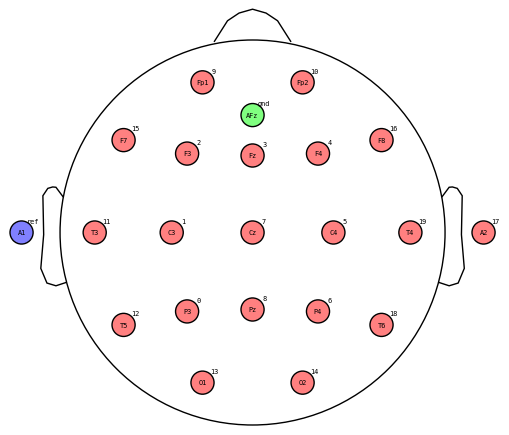

In [157]:
ch_set = ChannelSet(ch_info)
plt.figure(figsize=(5,5))
ch_set.plot()

#ch_set.get_labels()

In [158]:
# Bandpass filter
signalFilter = MI.filter_data(signal, fs, l_freq=1, h_freq=40)

# Re-reference
if montage_type == 'EGI_128':
    # Re-reference to mastoids
    signalFilter, ch_set = MI.spatial_filter(sfilt='REF', 
                                             ch_set=ch_set, 
                                             signal=signalFilter, 
                                             flag_ch='TP9 TP10', 
                                             verbose=True)

# Create RAW
RAW = MI.make_RAW(signalFilter * 1e-6, fs, ch_set.get_labels())
# Create montage based on channels to show
montage = MI.make_montage(montage_type=montage_type, 
                          ch_to_show=ch_set.get_labels(), 
                          conv_dict=eeg_dict.stand1020_to_egi)
# Assign montage to RAW
RAW.set_montage(montage)

<RawArray | 20 x 125400 (418.0 s), ~19.2 MB, data loaded>

In [159]:
# Run PREP for bad channels
MI.make_PREP(RAW, isSNR=True, isDeviation=True, isHfNoise=True, isNanFlat=True, isRansac=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Before RANSAC: []
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
After RANSAC: ['A2', 'C3', 'Cz', 'T3', 'T4']


In [138]:
# Mark BAD regions
MI.mark_BAD_region(RAW, block=True)


 --> Mark BAD regions (visually)


2024-03-22 14:05:04,266 - qdarkstyle - INFO - QSS file sucessfuly loaded.
2024-03-22 14:05:04,267 - qdarkstyle - INFO - Found version patches to be applied.
2024-03-22 14:05:04,267 - qdarkstyle - INFO - Found application patches to be applied.


Channels marked as bad:
['A2', 'C3', 'T4']


In [160]:
# Summary of BAD regions (confirm the marking)
MI.evaluate_BAD_region(RAW)

 --> BAD_region: 0 sections, ~0 s [0.0%] --> Bad channels: ['A2', 'C3', 'Cz', 'T3', 'T4']


In [161]:
# Add Stim to RAW
MI.make_RAW_stim(RAW, states)

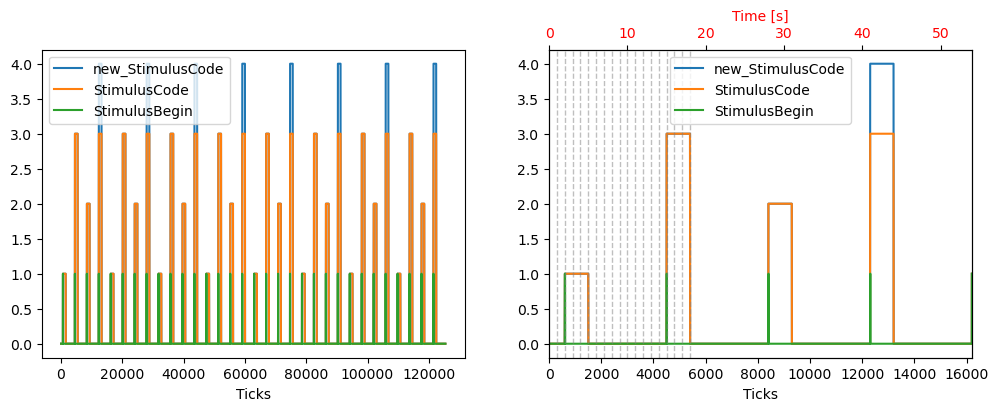


~~~~~~~~ ANNOTATIONS ~~~~~~~~
File length: 418.0 s or 125400 ticks
File length (remove initial pause): 416.0 s or 124800 ticks
Block length: 52.0 s or 15600.0 ticks
Command length: 13.0 s or 3900.0 ticks
	Stim length: 3.0 s or 900 ticks
	Task length: 10.0 s or 3000 ticks
Used Annotations descriptions: ['cue', 'left', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5', 'left_6', 'left_7', 'left_8', 'left_rest', 'left_rest_1', 'left_rest_2', 'left_rest_3', 'left_rest_4', 'left_rest_5', 'left_rest_6', 'left_rest_7', 'left_rest_8', 'right', 'right_1', 'right_2', 'right_3', 'right_4', 'right_5', 'right_6', 'right_7', 'right_8', 'right_rest', 'right_rest_1', 'right_rest_2', 'right_rest_3', 'right_rest_4', 'right_rest_5', 'right_rest_6', 'right_rest_7', 'right_rest_8']


/mnt/c/Users/scana/Dropbox/WCornell/develop/motorimagery/tools_mi.py:521: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  


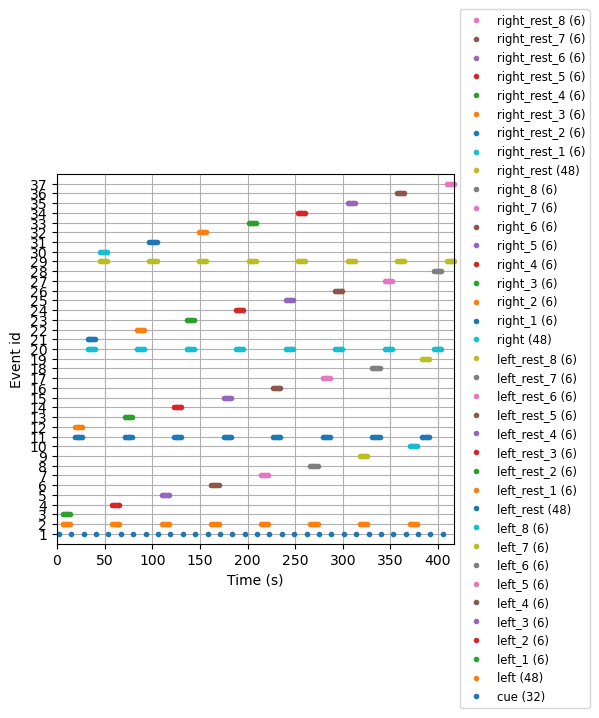

In [162]:
# Create annotations
RAW = MI.make_annotation_MI(RAW, fs,
                                nBlocks=nBlocks,
                                trialsPerBlock=trialsPerBlock,
                                initialSec=initialSec,
                                stimSec=stimSec,
                                taskSec=taskSec,
                                rejectSec=rejectSec,
                                nSplit=nSplit,
                                fileTime=fileTime)

In [163]:
# Summary of X region
MI.evaluate_BAD_region(RAW, 'BAD_region')
MI.evaluate_BAD_region(RAW, 'right_rest_1')

 --> BAD_region: 1 sections, ~2.0 s [0.5%] --> Bad channels: ['A2', 'C3', 'Cz', 'T3', 'T4']
 --> right_rest_1: 6 sections, ~9.0 s [2.2%] --> Bad channels: ['A2', 'C3', 'Cz', 'T3', 'T4']


In [164]:
ch_set.get_labels()

['P3',
 'C3',
 'F3',
 'Fz',
 'F4',
 'C4',
 'P4',
 'Cz',
 'Pz',
 'Fp1',
 'Fp2',
 'T3',
 'T5',
 'O1',
 'O2',
 'F7',
 'F8',
 'A2',
 'T6',
 'T4']

In [165]:
#if RAW.info['bads']==[]:
#    RAW.info['bads'] = ['F7']

In [166]:
old_ch_bads = MI.interpolate(RAW)

BAD CHANNELS to be interpolated: ['A2', 'C3', 'Cz', 'T3', 'T4']
Interpolating bad channels
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 5 sensors
RAW.info['bads'] have been modified


In [167]:
RAW.info['bads']

[]

In [168]:
old_ch_bads

['A2', 'C3', 'Cz', 'T3', 'T4']

In [169]:
#MI.show_electrode(ch_location=ch_location, ch_list=eeg_dict.ch_face + eeg_dict.ch_forehead, label=True)

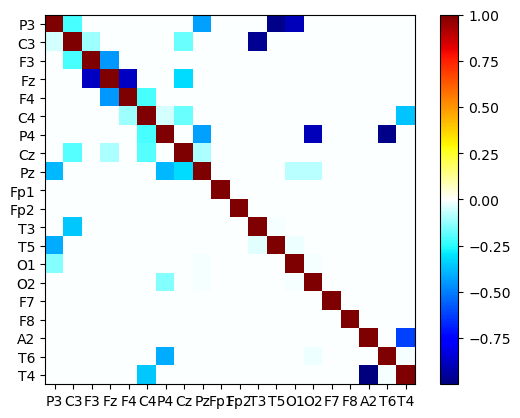

In [170]:
# Spatial filter with exclusion
signalSLAP, ch_setSLAP = MI.spatial_filter(sfilt= 'SLAP', 
                                           ch_set= ch_set, 
                                           signal= RAW.get_data(picks='eeg'), 
                                           flag_ch = eeg_dict.ch_face + eeg_dict.ch_forehead,
                                           verbose= True)

In [171]:
#MI.show_electrode(ch_location=ch_location, ch_list=eeg_dict.ch_face, label=True, color='red')

In [172]:
# Create RAW after spatial filter
RAW_SL = MI.make_RAW(signal=signalSLAP, fs=RAW.info['sfreq'], ch_names=ch_setSLAP.get_labels())
# Create montage based on channels to show
montage = MI.make_montage(montage_type=montage_type, 
                              ch_to_show=ch_setSLAP.get_labels(), 
                              conv_dict=eeg_dict.stand1020_to_egi)
# Assign montage to RAW_SL
RAW_SL.set_montage(montage)

# Add Stim to RAW_SL
MI.make_RAW_stim(RAW_SL, states)

# Import annotations
RAW_SL.set_annotations(RAW.annotations)

<RawArray | 40 x 125400 (418.0 s), ~38.3 MB, data loaded>

In [173]:
#RAW_SL.plot()

In [174]:
events_from_annot, event_dict = mne.events_from_annotations(RAW_SL)

Used Annotations descriptions: ['cue', 'left', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5', 'left_6', 'left_7', 'left_8', 'left_rest', 'left_rest_1', 'left_rest_2', 'left_rest_3', 'left_rest_4', 'left_rest_5', 'left_rest_6', 'left_rest_7', 'left_rest_8', 'right', 'right_1', 'right_2', 'right_3', 'right_4', 'right_5', 'right_6', 'right_7', 'right_8', 'right_rest', 'right_rest_1', 'right_rest_2', 'right_rest_3', 'right_rest_4', 'right_rest_5', 'right_rest_6', 'right_rest_7', 'right_rest_8']


In [175]:
def epochs_to_psd(RAW=None, fs=None, event_dict=None, label=None, events_from_annot=None, tmin=None, tmax=None, twindow=None, fmin=None, fmax=None, resolution=None, secPerSegment=1, secOverlap=0.5, nSkip=0):
    psds_ = []
    for i in range(1,9):
        if i>nSkip: 
            try:
                epochs_ = MI.make_epochs(RAW, 
                                         tmin=tmin, 
                                         tmax=tmax, 
                                         event_id=event_dict[label+f'{i}'], 
                                         events_from_annot=events_from_annot, verbose=False)
                
                #print(epochs_.get_data(picks='eeg').shape)

                psds_.append(MI.make_psd(epochs_, fs=fs, 
                                         resolution=resolution, 
                                         tmin=tmin, tmax=tmax, 
                                         fmin=fmin, fmax=fmax, 
                                         nPerSegment=int(secPerSegment * fs), 
                                         nOverlap=int(secOverlap * fs), 
                                         aggregate=True, verbose=True))
            except KeyError:
                print(f'{label}{i} not found')
        else: 
            print(f'Skipping epochs {i}')
    return np.stack(psds_)

In [178]:
psds_left.shape

(8, 20, 40)

In [184]:
nSkip = 0
secOverlap = 0.5
secPerSegment = 1.
resolution = 1


# epochs_to_psd(RAW=None, fs=None, event_dict=None, label=None, events_from_annot=None, tmin=None, tmax=None, twindow=None, fmin=None, fmax=None, resolution=None, secPerSegment=1, secOverlap=0.5, OnSkip=0)
psds_left = epochs_to_psd(RAW_SL, fs, event_dict, 'left_', events_from_annot, 
                          tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, resolution=resolution, 
                          secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_left_rest = epochs_to_psd(RAW_SL, fs, event_dict, 'left_rest_', events_from_annot, 
                               tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, resolution=resolution, 
                               secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_right = epochs_to_psd(RAW_SL, fs, event_dict, 'right_', events_from_annot, 
                           tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, resolution=resolution, 
                           secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

psds_right_rest = epochs_to_psd(RAW_SL, fs, event_dict, 'right_rest_', events_from_annot, 
                                tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, resolution=resolution, 
                                secPerSegment=secPerSegment, secOverlap=secOverlap, nSkip=nSkip)

Effective window size : 1.000 (s)
Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodograms): 2
Dimension check: (epoch, ch, bins, segments/periodograms) = (6, 20, 40, 2)
Aggregate segments/periodograms: (epoch, ch, bins) = (6, 20, 40)
Aggregate epoch-wise: (ch, bins) = (20, 40)
Effective window size : 1.000 (s)
Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodograms): 2
Dimension check: (epoch, ch, bins, segments/periodograms) = (6, 20, 40, 2)
Aggregate segments/periodograms: (epoch, ch, bins) = (6, 20, 40)
Aggregate epoch-wise: (ch, bins) = (20, 40)
Effective window size : 1.000 (s)
Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodogra

Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodograms): 2
Dimension check: (epoch, ch, bins, segments/periodograms) = (6, 20, 40, 2)
Aggregate segments/periodograms: (epoch, ch, bins) = (6, 20, 40)
Aggregate epoch-wise: (ch, bins) = (20, 40)
Effective window size : 1.000 (s)
Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodograms): 2
Dimension check: (epoch, ch, bins, segments/periodograms) = (6, 20, 40, 2)
Aggregate segments/periodograms: (epoch, ch, bins) = (6, 20, 40)
Aggregate epoch-wise: (ch, bins) = (20, 40)
Effective window size : 1.000 (s)
Expected w/ resolution 1 [Hz/bin]: 
  - Eff_Window Length [s]: 1.0
  - Epochs: 6 -> 1.5 s-long (per type)
  - Channels: 20
  - Bins: 40
  - Expected segments (or periodograms): 2
Dimension check: (epoch, ch

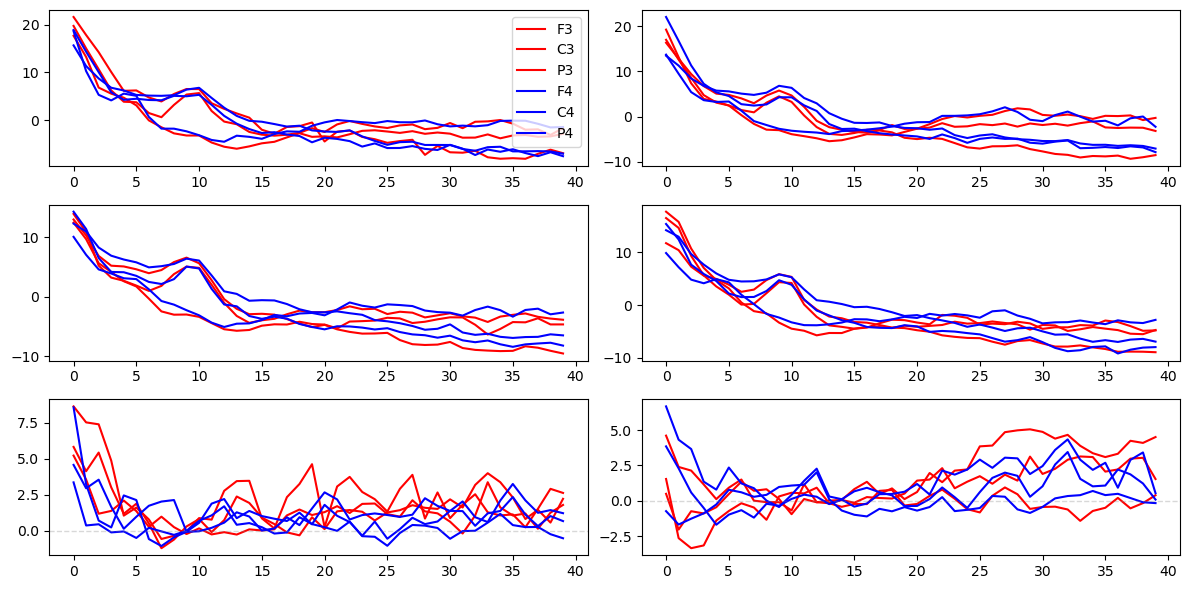

In [185]:
plt.figure(figsize=(12, 6))
axes = [plt.subplot(3, 2, i + 1) for i in range(6)]
colors = ['red', 'blue', 'black', 'red', 'blue', 'grey']
alphas = [1, 1, 0.2, 0.2, 0.2, 0.2]

data_sets = [MI.convert_dB(np.mean(psds_left_rest, axis=0)),
             MI.convert_dB(np.mean(psds_left, axis=0)),
             MI.convert_dB(np.mean(psds_right_rest, axis=0)),
             MI.convert_dB(np.mean(psds_right, axis=0)),
             MI.convert_dB(np.mean(psds_left_rest, axis=0)) - MI.convert_dB(np.mean(psds_left, axis=0)),
             MI.convert_dB(np.mean(psds_right_rest, axis=0)) - MI.convert_dB(np.mean(psds_right, axis=0))]

leg_titles = ['Rest (Left)', 'Task (Left)', 'Rest (Right)', 'Task (Right)', 'Diff (Left)', 'Diff (Right)']
xlim = (1, 40)
#ylim_left = [int(np.min(self.convert_dB(self.psd_left_rest_mean)))-5, int(np.max(self.convert_dB(self.psd_left_rest_mean)))+5]
#ylim_right = [int(np.min(self.convert_dB(self.psd_right_rest_mean)))-5, int(np.max(self.convert_dB(self.psd_right_rest_mean)))+5]
#ylims = [ylim_left, ylim_right, ylim_left, ylim_right]

axes[0].plot(data_sets[0][ch_setSLAP.find_labels('F3')[0]], color='red', label='F3')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('F3')[0]], color='red')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('F3')[0]], color='red')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('F3')[0]], color='red')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('F3')[0]], color='red')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('F3')[0]], color='red')

axes[0].plot(data_sets[0][ch_setSLAP.find_labels('C3')[0]], color='red', label='C3')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('C3')[0]], color='red')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('C3')[0]], color='red')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('C3')[0]], color='red')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('C3')[0]], color='red')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('C3')[0]], color='red')

axes[0].plot(data_sets[0][ch_setSLAP.find_labels('P3')[0]], color='red', label='P3')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('P3')[0]], color='red')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('P3')[0]], color='red')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('P3')[0]], color='red')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('P3')[0]], color='red')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('P3')[0]], color='red')



axes[0].plot(data_sets[0][ch_setSLAP.find_labels('F4')[0]], color='blue', label='F4')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('F4')[0]], color='blue')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('F4')[0]], color='blue')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('F4')[0]], color='blue')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('F4')[0]], color='blue')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('F4')[0]], color='blue')

axes[0].plot(data_sets[0][ch_setSLAP.find_labels('C4')[0]], color='blue', label='C4')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('C4')[0]], color='blue')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('C4')[0]], color='blue')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('C4')[0]], color='blue')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('C4')[0]], color='blue')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('C4')[0]], color='blue')

axes[0].plot(data_sets[0][ch_setSLAP.find_labels('P4')[0]], color='blue', label='P4')
axes[2].plot(data_sets[1][ch_setSLAP.find_labels('P4')[0]], color='blue')
axes[1].plot(data_sets[2][ch_setSLAP.find_labels('P4')[0]], color='blue')
axes[3].plot(data_sets[3][ch_setSLAP.find_labels('P4')[0]], color='blue')
axes[4].plot(data_sets[4][ch_setSLAP.find_labels('P4')[0]], color='blue')
axes[5].plot(data_sets[5][ch_setSLAP.find_labels('P4')[0]], color='blue')


axes[4].axhline(0, lw=1, ls='--', color='grey', alpha=0.3)
axes[5].axhline(0, lw=1, ls='--', color='grey', alpha=0.3)

axes[0].legend()
plt.tight_layout()
plt.show()

In [186]:
isLeft_ch = [x for x in MI.find_ch_circle(eeg_dict.ch_location, radius=0.74) if x in MI.find_ch_left(eeg_dict.ch_location)]
isRight_ch = [x for x in MI.find_ch_circle(eeg_dict.ch_location, radius=0.74) if x in MI.find_ch_right(eeg_dict.ch_location)]


isLeft = np.array([True if x in isLeft_ch else False for x in ch_setSLAP.get_labels()])
isRight = np.array([True if x in isRight_ch else False for x in ch_setSLAP.get_labels()])

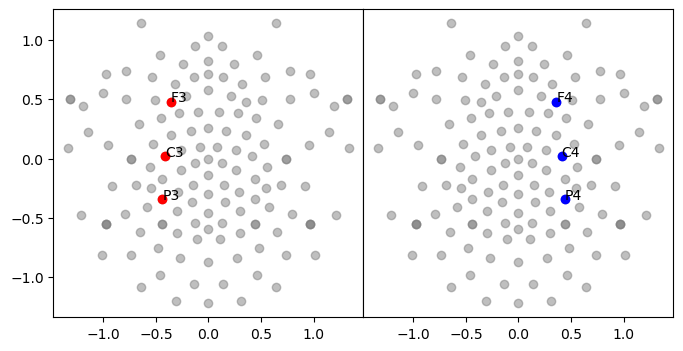

In [187]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
left_labels = [x for x, y in zip(ch_setSLAP.get_labels(), isLeft) if y == True]
MI.show_electrode(ch_location, left_labels, True, 'red')
plt.subplot(122)
right_labels = [x for x, y in zip(ch_setSLAP.get_labels(), isRight) if y == True]
MI.show_electrode(ch_location, right_labels, True, 'blue')
plt.yticks([])
plt.subplots_adjust(wspace=0)  # Remove space between plots
plt.show()

In [ ]:
#r2(x, isTreatment)

In [ ]:
#CalculateEtas(x, isTreatment)

In [ ]:
bins_ticks = np.arange(fmin, fmax+1, int(resolution))
theta_ticks = np.where((bins_ticks>=4) & (bins_ticks<=7))[0]
alpha_ticks = np.where((bins_ticks>=8) & (bins_ticks<=12))[0]
beta_ticks = np.where((bins_ticks>=13) & (bins_ticks<=30))[0]

# Create statistics to test in nonparametric tests
N = 1999
perm_bool = True
boot_bool = False

p_left = []
p_right = []
labels = []

In [ ]:
psds_left.shape

In [ ]:
bins_ticks = np.arange(1, 40+1, int(1))
theta_ticks = np.where((bins_ticks>=4) & (bins_ticks<=7))[0]
alpha_ticks = np.where((bins_ticks>=8) & (bins_ticks<=12))[0]
beta_ticks = np.where((bins_ticks>=13) & (bins_ticks<=30))[0]

In [ ]:
def ch_xray(psds_rest=None, psds_task=None, ch=None, fmin=None, fmax=None, resolution=None, ch_set=None):
    # psds_rest
    # psds_task
    # ch
    # fmin
    # fmax
    # resolution

    # Find channel id
    ch_id = ch_set.find_labels(ch)[0]
    # Find symmetric channel id
    ch_symm = MI.find_ch_symmetry(ch_location=eeg_dict.ch_location, ch_list=[ch])[ch]
    ch_symm_id = ch_set.find_labels(ch_symm)[0]

    # Define bins and frequency regions
    bins_ticks = np.arange(fmin, fmax+1, int(resolution))
    theta_ticks = np.where((bins_ticks>=4) & (bins_ticks<=7))[0]
    alpha_ticks = np.where((bins_ticks>=8) & (bins_ticks<=12))[0]
    beta_ticks = np.where((bins_ticks>=13) & (bins_ticks<=30))[0]

    xlim = (fmin, fmax)
    #ylim = (1e-14, 1e-10)
    ylim = (-30, 30)

    # Create a figure with 4 rows and 3 columns of subplots
    fig, axs = plt.subplots(4, 3, figsize=(15, 4), sharex='col', constrained_layout=False)
    # Loop through all subplots to adjust visibility
    for i in range(4):
        for j in range(3):
            # For the first 2 columns, hide x-axis labels and ticks for all but the bottom row
            if j in [0, 1] and i < 3:
                axs[i, j].tick_params(labelbottom=False)
            # For the third column, make first 3 plots empty and hide their axes
            if j == 2 and i < 3:
                axs[i, j].axis('off')
            # You can add your plotting code for each subplot here, for example:
            # axs[i, j].plot(data)

    def plot_trials(ax=None, psds=None, color=None, label=None):
        for i in range(psds.shape[0]):
            y = psds[i] # (trial, bin)
            ax.plot(bins_ticks, MI.convert_dB(y), color=color, alpha=0.1)
    
        y = np.mean(psds, axis=0) # (bin,)
        y_flat =  [ np.mean(y[ theta_ticks[0] : theta_ticks[-1] ], axis=0) ] * len(theta_ticks)
        y_flat += [ np.mean(y[ alpha_ticks[0] : alpha_ticks[-1] ], axis=0) ] * len(alpha_ticks)
        y_flat += [ np.mean(y[ beta_ticks[0]  : beta_ticks[-1]  ], axis=0) ] * len(beta_ticks)
        y_flat = np.array(y_flat)
        ax.plot(bins_ticks[np.hstack([theta_ticks, alpha_ticks, beta_ticks]).ravel()], MI.convert_dB(y_flat), color=color, alpha=1, label=label)
        ax.legend(loc='upper right')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #ax.set_yscale('log')
        MI.plot_frequency_bands(ax=ax, ylim=ylim)
        return y_flat
    
    def plot_diff(ax=None, psds1=None, psds2=None, color=None, label=None):
        ax.plot(bins_ticks[np.hstack([theta_ticks, alpha_ticks, beta_ticks]).ravel()], MI.convert_dB(np.array(psds1)-np.array(psds2)), color=color, alpha=1, label=label)
        ax.legend(loc='upper right')
        ax.set_xlim(xlim)
        ax.set_ylim([x*0.5 for x in ylim])
        ax.axhline(0, lw=1, ls='--', color='grey')
        #ax.set_yscale('log')
        MI.plot_frequency_bands(ax=ax)
        print((np.array(psds1)-np.array(psds2))[ch_symm_id])
        
    def extract_r2(psds1=None, psds2=None, bins=None):
        x = np.mean(np.vstack([psds1, psds2])[:,:,bins[0]:bins[-1]], axis=2)
        isTreatment = np.arange(x.shape[0]) < psds1.shape[0]
        T = mi.SumsR2(ch_set=ch_set, dict_symm=None, isContralat=None, bins=bins, transf='r2')
        return T.Transform(x,isTreatment)
    
    psds_rest_ch_flat = plot_trials(ax=axs[0,0], psds=psds_rest[:, ch_id, :], color='purple', label=f'Rest {ch}')
    psds_task_ch_flat = plot_trials(ax=axs[1,0], psds=psds_task[:, ch_id, :], color='red', label=f'Task {ch}')
    psds_rest_ch_symm_flat = plot_trials(ax=axs[0,1], psds=psds_rest[:, ch_symm_id, :], color='purple', label=f'Rest {ch_symm}')
    psds_task_ch_symm_flat = plot_trials(ax=axs[1,1], psds=psds_task[:, ch_symm_id, :], color='red', label=f'Task {ch_symm}')

    plot_diff(ax=axs[2,0], psds1=psds_rest_ch_flat, psds2=psds_task_ch_flat, color='blue', label=f'Diff {ch}')
    plot_diff(ax=axs[2,1], psds1=psds_rest_ch_symm_flat, psds2=psds_task_ch_symm_flat, color='blue', label=f'Diff {ch_symm}')
    
    r2_ch = [extract_r2(psds1=psds_rest, psds2=psds_task, bins=theta_ticks)[ch_id]] * len(theta_ticks)
    r2_ch += [extract_r2(psds1=psds_rest, psds2=psds_task, bins=alpha_ticks)[ch_id]] * len(alpha_ticks)
    r2_ch += [extract_r2(psds1=psds_rest, psds2=psds_task, bins=beta_ticks)[ch_id]] * len(beta_ticks)
    axs[3,0].plot(bins_ticks[np.hstack([theta_ticks, alpha_ticks, beta_ticks]).ravel()], r2_ch)
    axs[3,0].set_ylim((-.1, .1))
    MI.plot_frequency_bands(ax=axs[3,0])
    
    r2_ch_symm = [extract_r2(psds1=psds_rest, psds2=psds_task, bins=theta_ticks)[ch_symm_id]] * len(theta_ticks)
    r2_ch_symm += [extract_r2(psds1=psds_rest, psds2=psds_task, bins=alpha_ticks)[ch_symm_id]] * len(alpha_ticks)
    r2_ch_symm += [extract_r2(psds1=psds_rest, psds2=psds_task, bins=beta_ticks)[ch_symm_id]] * len(beta_ticks) 
    axs[3,1].plot(bins_ticks[np.hstack([theta_ticks, alpha_ticks, beta_ticks]).ravel()], r2_ch_symm)
    axs[3,1].set_ylim((-.1, .1))
    MI.plot_frequency_bands(ax=axs[3,1])
    
    axs[3,2].plot(bins_ticks[np.hstack([theta_ticks, alpha_ticks, beta_ticks]).ravel()], [x-y for x,y in zip(r2_ch, r2_ch_symm)])
    axs[3,2].set_ylim((-.1, .1))
    MI.plot_frequency_bands(ax=axs[3,2])

    # Adjust subplot parameters if needed
    plt.subplots_adjust(hspace=0., wspace=0.1)
    plt.show()

In [ ]:
MI.convert_dB(-7.0402038960085e-14)

In [ ]:
ch_xray(psds_rest=psds_left_rest, psds_task=psds_left, ch='F3', fmin=1, fmax=40, resolution=1, ch_set=ch_set)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create a figure
fig = plt.figure(figsize=(15, 10))

# Set up a gridspec with 4 rows and 3 columns
gs = gridspec.GridSpec(4, 3, figure=fig)

# Create subplots in the first two columns
axs = []
for i in range(4):
    for j in range(2):
        ax = fig.add_subplot(gs[i, j])
        # For the first 2 columns, hide x-axis labels and ticks for all but the bottom row
        if i < 3:
            ax.tick_params(labelbottom=False)
        axs.append(ax)

# Create a merged subplot in the third column, spanning rows 0 and 1
ax_merged = fig.add_subplot(gs[0:2, 2])

# Create individual subplots for the remaining positions in the third column
ax3 = fig.add_subplot(gs[2, 2])
ax4 = fig.add_subplot(gs[3, 2])

# Hide axes for ax3 (as per your initial setup)
ax3.axis('off')

# Example plot in the merged area and the bottom subplot of the third column
ax_merged.set_title("Merged Plot")
ax4.set_title("Visible Plot")
ax_merged.plot([0, 1], [0, 1])  # Example line plot in merged area
ax4.plot([0, 1], [0, 1])  # Example line plot in the bottom subplot

# Adjust layout
plt.tight_layout()

plt.show()


In [ ]:
# LEFT HAND TEST
x = np.vstack([psds_left_rest, psds_left])
isTreatment = np.arange(x.shape[0]) < psds_left_rest.shape[0]

# theta
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isRight, bins=theta_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_left.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_left.append(p)
    
labels.append(r'4-7 Hz')
x_left_theta = np.mean(x[:, :, theta_ticks[0]:theta_ticks[-1]], axis=2)
r2_left_theta = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# alpha
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isRight, bins=alpha_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_left.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_left.append(p)

x_left_alpha = np.mean(x[:, :, alpha_ticks[0]:alpha_ticks[-1]], axis=2)
labels.append(r'8-12 Hz')
r2_left_alpha = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# beta
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isRight, bins=beta_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_left.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_left.append(p)

x_left_beta = np.mean(x[:, :, beta_ticks[0]:beta_ticks[-1]], axis=2)
labels.append(r'13-30 Hz')
r2_left_beta = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# RIGHT HAND TESTS
x = np.vstack([psds_right_rest, psds_right])
isTreatment = np.arange(x.shape[0]) < psds_right_rest.shape[0]

# theta
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isLeft, bins=theta_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_right.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_right.append(p)

x_right_theta = np.mean(x[:, :, theta_ticks[0]:theta_ticks[-1]], axis=2)
#labels.append(r'4-7 Hz')
r2_right_theta = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# alpha
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isLeft, bins=alpha_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_right.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_right.append(p)

x_right_alpha = np.mean(x[:, :, alpha_ticks[0]:alpha_ticks[-1]], axis=2)
#labels.append(r'8-12 Hz')
r2_right_alpha = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# beta
T = mi.SumsR2(ch_set=ch_setSLAP, dict_symm=eeg_dict.dict_symm, isContralat=isLeft, bins=beta_ticks)
if perm_bool:
    p = MI.ApproxPermutationTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N )
    p_right.append(p)
if boot_bool:
    p = MI.BootstrapTest(x=x, isTreatment=isTreatment, stat=T.DifferenceOfSumsR2, nSimulations=N, nullHypothesisStatValue=0.0 )
    p_right.append(p)

x_right_beta = np.mean(x[:, :, beta_ticks[0]:beta_ticks[-1]], axis=2)
#labels.append(r'13-30 Hz')
r2_right_beta = T.DifferenceOfR2(x, isTreatment)

In [ ]:
# MERGE LEFTvsRIGHT TESTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5), sharey=True)
y_max = 0.5
y_min = -0.5
y = np.linspace(start=y_max, stop=y_min, num=len(p_left)+2)
y = y[1:-1]
deltay = 0.075
# LEFT RESULTS
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_left:
    p_down, p, p_up = MI.pvalue_interval(p, N+1)
    xUp_values.append(MI.negP(p_up))
    x_values.append(MI.negP(p))
    xDown_values.append(MI.negP(p_down))
#---------
ax1.set_title('Open/Close Left')
ax1.scatter(x_values, y, color='red', marker='.')
# Add confidence interval on true p
for i in range(len(y)):
    ax1.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='red', alpha=0.3)
ax1.hlines(y, 0, x_values, colors='red', lw=1, alpha=0.25)
ax1.set_xlabel(r'-log($p$)')
ax1.set_xlim(ax1.get_xlim()[::-1])  # Reverse the x-axis for left plot
ax1.set_xlim(right=0, left=8)
ax1.set_ylim(y_min, y_max)
ax1.axvline(MI.negP(0.05), color='cornflowerblue', lw=1, ls='--', alpha=0.5, label='95% C.L.')
ax1.axvline(MI.negP(0.01), color='black', lw=1, ls='--', alpha=0.5, label='99% C.L.')
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.legend(loc='upper left')
# RIGHT RESULTS
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_right:
    p_down, p, p_up = MI.pvalue_interval(p, N+1)
    xUp_values.append(MI.negP(p_up))
    x_values.append(MI.negP(p))
    xDown_values.append(MI.negP(p_down))
#---------
ax2.set_title('Open/Close Right')
ax2.scatter(x_values, y, color='blue', marker='.')
# Add confidence interval on true p
for i in range(len(y)):
    ax2.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='blue', alpha=0.3)
ax2.hlines(y, 0, x_values, colors='blue', lw=1, alpha=0.25)
ax2.set_xlabel(r'-log($p$)')
ax2.set_xlim(left=0, right=8)
ax1.set_ylim(y_min, y_max)
ax2.axvline(MI.negP(0.05), color='cornflowerblue', lw=1, ls='--', alpha=0.5)
ax2.axvline(MI.negP(0.01), color='black', lw=1, ls='--', alpha=0.5)
#--------- 
plt.subplots_adjust(wspace=0)  # Adjust space between subplots
plt.show()

In [ ]:
def plot_topomap_L_R(ax, RAW, dataL, dataR, cmap, vlim, masks, mask_params, text_range, text=None):
    # 
    im,cm = mne.viz.plot_topomap(dataL, RAW.info, ch_type='eeg', sensors=True, cmap=cmap, vlim=vlim, mask=masks[0], mask_params=mask_params[0], show=False, axes=ax[0]) 
    im,cm = mne.viz.plot_topomap(dataL, RAW.info, ch_type='eeg', sensors=True, cmap=cmap, vlim=vlim, mask=masks[1], mask_params=mask_params[1], show=False, axes=ax[0]) 
    ax[0].set_title(f"{text_range} (Left)")
    im,cm = mne.viz.plot_topomap(dataR, RAW.info, ch_type='eeg', sensors=True, cmap=cmap, vlim=vlim, mask=masks[0], mask_params=mask_params[0], show=False, axes=ax[1])
    im,cm = mne.viz.plot_topomap(dataR, RAW.info, ch_type='eeg', sensors=True, cmap=cmap, vlim=vlim, mask=masks[2], mask_params=mask_params[1], show=False, axes=ax[1])
    ax[1].set_title(f"{text_range} (Right)")
    # Color bar
    clim = dict(kind='value', lims=[-1,0,1])
    divider = make_axes_locatable(ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([])
    ax[2].axis('off')
    ax[2] = divider.append_axes(position='left', size='20%', pad=0.5)
    mne.viz.plot_brain_colorbar(ax[2], clim=clim, colormap=cmap, transparent=False, orientation='vertical', label=None)
    if text: 
        #ax[2].plot(0, 0.5, marker='o', markersize=8, markerfacecolor='lime')
        #ax[2].plot(0, 0.35, marker='X', markersize=7, markerfacecolor='black')  # Plot a single blue point at (1,1)
        ax[2].text(3, 0.26, 'Target', color='lime')
        ax[2].text(3, 0.25,'Target', color='black')
        #ax[2].text(3, 0.11, 'Interpolated', color='black')
        ax[2].text(3, 0.1, 'Interpolated', color='black')

In [ ]:
def make_cmap(cmap, name, n=256):
    cmap = LinearSegmentedColormap(name, cmap, n)
    if name not in plt.colormaps():
        try:
            matplotlib.cm.register_cmap(name=name, cmap=cmap)
        except Exception as e:
            print(f"Failed to register colormap '{name}'. Error: {str(e)}")
    return cmap

# Define the colormap dictionary
kelvin_i = {
    'red': (
        (0.000, 0.0, 0.0),
        (0.350, 0.0, 0.0),
        (0.500, 1.0, 1.0),
        (0.890, 1.0, 1.0),
        (1.000, 0.5, 0.5),
    ),
    'green': (
        (0.000, 0.0, 0.0),
        (0.125, 0.0, 0.0),
        (0.375, 1.0, 1.0),
        (0.640, 1.0, 1.0),
        (0.910, 0.0, 0.0),
        (1.000, 0.0, 0.0),
    ),
    'blue': (
        (0.000, 0.5, 0.5),
        (0.110, 1.0, 1.0),
        (0.500, 1.0, 1.0),
        (0.650, 0.0, 0.0),
        (1.000, 0.0, 0.0),
    ),
}

# Create and register the custom colormap
kelvin_i_cmap = make_cmap(kelvin_i, 'kelvin_i', 256)



# Identify interpolated channels to show on the topomap
mask = np.array([True if x in old_ch_bads else False for x in ch_setSLAP.get_labels()])
mask_params1 = dict(marker='X', markersize=7, markerfacecolor='black')
# Identify target channels to show on the topomap
mask_right = np.array([True if x in isLeft_ch else False for x in ch_setSLAP.get_labels()])
mask_left = np.array([True if x in isRight_ch else False for x in ch_setSLAP.get_labels()])
mask_params2 = dict(marker='o', markersize=4, markerfacecolor='lime', alpha=1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 6))
# Plot topoplots - Theta
colors = [(0.0, 'blue'),     # Color at -1
          (0.5, 'white'),    # Color at 0
          (1.0, 'red')]      # Color at 1
custom_cmap_theta = LinearSegmentedColormap.from_list('custom_cmap', colors)
plot_topomap_L_R([axes[0,0],axes[0,1],axes[0,2]], RAW_SL, r2_left_theta, r2_right_theta, custom_cmap_theta, (-1,1), [mask,mask_left,mask_right], [mask_params1,mask_params2], '4-7 Hz', True)

# Plot topoplots - Alpha
#colors = [(0.0, 'turquoise'),     # Color at -1
#          (0.5, 'white'),    # Color at 0
#          (1.0, 'magenta')]      # Color at 1#
custom_cmap_alpha = LinearSegmentedColormap.from_list('custom_cmap', colors)
plot_topomap_L_R([axes[1,0],axes[1,1],axes[1,2]], RAW_SL, r2_left_alpha, r2_right_alpha, custom_cmap_alpha, (-1,1), [mask,mask_left,mask_right], [mask_params1,mask_params2], '8-12 Hz', False)

# Plot topoplots - Beta
#colors = [(0.0, 'royalblue'),     # Color at -1
#          (0.5, 'white'),    # Color at 0
#          (1.0, 'orangered')]      # Color at 1
custom_cmap_beta = LinearSegmentedColormap.from_list('custom_cmap', colors)
plot_topomap_L_R([axes[2,0],axes[2,1],axes[2,2]], RAW_SL, r2_left_beta, r2_right_beta, custom_cmap_beta, (-1,1), [mask,mask_left,mask_right], [mask_params1,mask_params2], '13-30 Hz', False)

axes[0,3].set_yticks([])
axes[0,3].set_xticks([])
axes[0,3].axis('off')

axes[1,3].set_yticks([])
axes[1,3].set_xticks([])
axes[1,3].axis('off')

axes[2,3].set_yticks([])
axes[2,3].set_xticks([])
axes[2,3].axis('off')
fig.tight_layout()
plt.show()

In [225]:
def L1(x1=None, x2=None):
    # Manhattan
    return np.sum(np.abs(x1 - x2))

def L2(x1=None, x2=None):
    # Euclidean
    return np.sqrt(np.sum((x1 - x2) ** 2))

def Lp(x1=None, x2=None, p=4):
    # Minkovski (generalizes Euclidean)
    return np.sum(np.abs(x1 - x2) ** p) ** (1/p)

def Linf(x1=None, x2=None):
    # Chebishev
    return np.max(np.abs(x1 - x2))

def distance_matrix(x=None, distance=L2):
    n = x.shape[0]
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j >= i: d[i,j] = distance(x[i], x[j])
            else: d[i,j] = d[j,i]
    return d

def gaussian(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2*np.pi))

def gauss_affinity(d, sigma, neg=False):
    n = d.shape[0]
    a = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            a[i,j] = gaussian(d[i,j], sigma)
        
    for i in range(n):
        a[i,:] /= np.sum(a[i,:])
            
    if neg: 
        for i in range(n): 
            a[i,i] = 0
    return a

In [226]:
x = [0,  0.5,  -0.5,   0.75, 0,   -0.75]
y = [0, -0.25, -0.25, -0.5, -0.5, -0.5 ]
X = np.array([x,
              y])

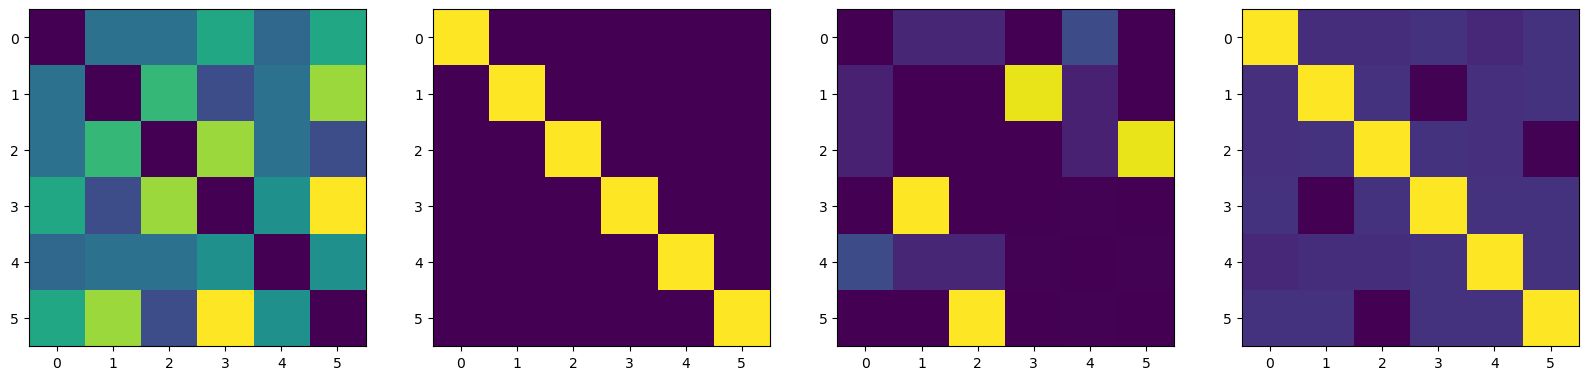

In [228]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(distance_matrix(X))
plt.subplot(142)
plt.imshow(gauss_affinity(d2(X), 0.04))
plt.subplot(143)
plt.imshow(gauss_affinity(d2(X), 0.20, neg=True))
plt.subplot(144)
plt.imshow(gauss_affinity(d2(X), 0.04) - gauss_affinity(d2(X), 0.20, neg=True))
plt.show()

In [ ]:
## Paper p-values

In [ ]:
paper_result = {'TD1'    : [0.0155, 0.0085],
                'TD2'    : [0.2585, 0.0295],
                'TD3'    : [0.4905, 0.2365],
                'TD4'    : [0.0015, 0.1905],
                'TD5'    : [0.0265, 0.0085],
                'TD6'    : [0.0145, 0.1445],
                'TD7'    : [0.9645, 0.9825],
                'TD8'    : [0.0145, 0.0825],
                'TD9'    : [0.0355, 0.0365],
                'TD10'   : [0.0075, 0.3795]}

p_left = [value[0] for key, value in paper_result.items()]
p_right = [value[1] for key, value in paper_result.items()]
labels = [x for x in paper_result.keys()]


# MERGE LEFTvsRIGHT TESTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
y_max = 0.5
y_min = -0.5
y = np.linspace(start=y_max, stop=y_min, num=len(p_left)+2)
y = y[1:-1]
deltay = 0.075
# LEFT RESULTS
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_left:
    p_down, p, p_up = MI.pvalue_interval(p, N+1)
    xUp_values.append(MI.negP(p_up))
    x_values.append(MI.negP(p))
    xDown_values.append(MI.negP(p_down))
#---------
ax1.set_title('Open/Close Left')
ax1.scatter(x_values, y, color='red', marker='.')
# Add confidence interval on true p
for i in range(len(y)):
    ax1.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='red', alpha=0.3)
ax1.hlines(y, 0, x_values, colors='red', lw=1, alpha=0.25)
ax1.set_xlabel(r'-log($p$)')
ax1.set_xlim(ax1.get_xlim()[::-1])  # Reverse the x-axis for left plot
ax1.set_xlim(right=0, left=8)
ax1.set_ylim(y_min, y_max)
ax1.axvline(MI.negP(0.05), color='black', lw=1, ls='--', alpha=0.5, label='95% C.L.')
ax1.axvline(MI.negP(0.01), color='cornflowerblue', lw=1, ls='--', alpha=0.5, label='99% C.L.')
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.legend(loc='upper left')
# RIGHT RESULTS
#---------
x_values = []
xUp_values = []
xDown_values = []
for p in p_right:
    p_down, p, p_up = MI.pvalue_interval(p, N+1)
    xUp_values.append(MI.negP(p_up))
    x_values.append(MI.negP(p))
    xDown_values.append(MI.negP(p_down))
#---------
ax2.set_title('Open/Close Right')
ax2.scatter(x_values, y, color='blue', marker='.')
# Add confidence interval on true p
for i in range(len(y)):
    ax2.fill_betweenx([y[i]-deltay, y[i]+deltay], xDown_values[i], xUp_values[i], color='blue', alpha=0.3)
ax2.hlines(y, 0, x_values, colors='blue', lw=1, alpha=0.25)
ax2.set_xlabel(r'-log($p$)')
ax2.set_xlim(left=0, right=8)
ax1.set_ylim(y_min, y_max)
ax2.axvline(MI.negP(0.05), color='black', lw=1, ls='--', alpha=0.5)
ax2.axvline(MI.negP(0.01), color='cornflowerblue', lw=1, ls='--', alpha=0.5)
#--------- 
plt.subplots_adjust(wspace=0)  # Adjust space between subplots
plt.show()

In [188]:
## Paper PSDs

In [ ]:
import scipy

In [ ]:
mat = scipy.io.loadmat('/mnt/c/Users/scana/Desktop/MI_test/TD7.mat')
td1_signal = mat['Alpha']
td_ch = mat['ChannelList']
td_ch = [ch[0] for ch in td_ch[0]]

td_condition = mat['condition']
td_condition = [ch[0] for ch in td_condition[0]]
np.mean(td1_signal[8:16], axis=0)

In [ ]:
MI.convert_dB(np.mean(x_right_alpha, axis=0))

In [189]:
## Test with Jeremy library

In [ ]:
import PermutationVsBootstrap as pb

In [ ]:
x = np.random.normal(0,1,100)
isTreatment = np.arange(len(x)) < len(x)//3

In [ ]:
case1 = []
case2 = []

for i in range(100):
    case1.append(pb.BootstrapTest(x,
                                  isTreatment,
                                  stat=pb.DifferenceOfGroupMeans,
                                  nSimulations=1999))


    #case2.append(MI.BootstrapTest(x,
    case2.append(MI.ApproxPermutationTest(x,
                                          isTreatment,
                                          stat=pb.DifferenceOfGroupMeans,
                                          nSimulations=1999))

In [ ]:
plt.scatter(case1, case2)

In [190]:
## Markhov chain predictions

In [ ]:
# States: Sunny, Rainy, Cloudy
states = ['Sunny', 'Rainy', 'Cloudy']

# Transition Matrix
transition_matrix = np.array([[0.8, 0.1, 0.1],  # From Sunny to [Sunny, Rainy, Cloudy]
                              [0.4, 0.4, 0.2],  # From Rainy to [Sunny, Rainy, Cloudy]
                              [0.2, 0.3, 0.5]]) # From Cloudy to [Sunny, Rainy, Cloudy]

def simulate_weather(days, initial_state):
    # Make sure initial_state is valid
    if initial_state not in states:
        return "Invalid initial state."
    
    # Initial state index
    current_state_idx = states.index(initial_state)
    weather_simulation = [initial_state]
    
    for _ in range(days - 1):
        current_state_idx = np.random.choice([0, 1, 2], p=transition_matrix[current_state_idx])
        weather_simulation.append(states[current_state_idx])
    
    return weather_simulation

# Simulate weather for 10 days, starting from 'Sunny'
N = 100000
simulation_result = np.array(simulate_weather(N, 'Sunny'))
p1 = np.sum(simulation_result=='Sunny')/N
p2 = np.sum(simulation_result=='Rainy')/N
p3 = np.sum(simulation_result=='Cloudy')/N
p  = p1 + p2 + p3 
print(f"P(Sunny): {p1}")
print(f"P(Rainy): {p2}")
print(f"P(Cloudy):{p3}")
print(f"P: {p}")
#print("Weather simulation starting from Sunny:", simulation_result)